<a href="https://colab.research.google.com/github/pumazzo/ML-ISS2025/blob/main/Lesson_5_Shap_xgboost_ISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP Interpretation with XGBoost on Diabetes Dataset
This notebook demonstrates how to train an **XGBoost** regression model on the classic diabetes dataset, evaluate its performance, and interpret the predictions using **SHAP (SHapley Additive exPlanations)**.

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Modeling
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Explainability
import shap

# Visualization
import matplotlib.pyplot as plt

# Initialize JS for SHAP visualisations inside Jupyter
shap.initjs()


### What is SHAP?

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting machine learning model predictions. It is based on concepts from cooperative game theory, specifically **Shapley values**, which assign each feature an importance value for a particular prediction. The Shapley value of a feature represents its **average contribution** to the model's output across all possible combinations of input features. For a prediction function \( f(x) \), the SHAP explanation model decomposes the output as:

$$
f(x) = \phi_0 + \sum_{i=1}^M \phi_i
$$

Here, \( \phi_0 \) is the expected output of the model, and \( \phi_i \) is the contribution of feature \( i \) to the prediction. SHAP values satisfy important properties such as **local accuracy**, **consistency**, and **missingness**, making them one of the most theoretically sound and widely adopted interpretability tools. SHAP can explain individual predictions (local interpretability) and reveal overall feature importance (global interpretability).

In [2]:
# Load the diabetes dataset bundled with SHAP
X, y = shap.datasets.diabetes()
y = y/350
print(f"Dataset shape: {X.shape}, Target length: {y.shape}")
display(X.head())


Dataset shape: (442, 10), Target length: (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


# Attribute Information:
  - age  =   age in years
  - sex
  - bmi  =   body mass index
  - bp   =   average blood pressure
  - s1   =   tc, total serum cholesterol
  - s2   =   ldl, low-density lipoproteins
  - s3   =   hdl, high-density lipoproteins
  - s4   =   tch, total cholesterol / HDL
  - s5   =   ltg, possibly log of serum triglycerides level
  - s6   =   glu, blood sugar level

  We can write mere descriptive names for our data
### target
  the target $y$ is a quantitative measure of disease progression one year after baseline. It is a continuous numerical value, suitable for regression tasks.

In [3]:
def rename_diabetes_features(df):
    """
    Rename the standard diabetes dataset columns to more descriptive names.

    Parameters:
    - df (pd.DataFrame): Original dataset with short feature names.

    Returns:
    - pd.DataFrame: Dataset with renamed columns.
    """
    column_mapping = {
        "age": "Age (years)",
        "sex": "Sex",
        "bmi": "Body Mass Index",
        "bp": "Average Blood Pressure",
        "s1": "Total Cholesterol (TC)",
        "s2": "LDL (Low-Density Lipoproteins)",
        "s3": "HDL (High-Density Lipoproteins)",
        "s4": "TC/HDL Ratio",
        "s5": "Log(Triglycerides)",
        "s6": "Blood Sugar Level (Glucose)"
    }
    return df.rename(columns=column_mapping)

X_renamed = rename_diabetes_features(X)

# Display the first few rows
X_renamed.head()

,Age (years),Sex,Body Mass Index,Average Blood Pressure,Total Cholesterol (TC),LDL (Low-Density Lipoproteins),HDL (High-Density Lipoproteins),TC/HDL Ratio,Log(Triglycerides),Blood Sugar Level (Glucose)
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


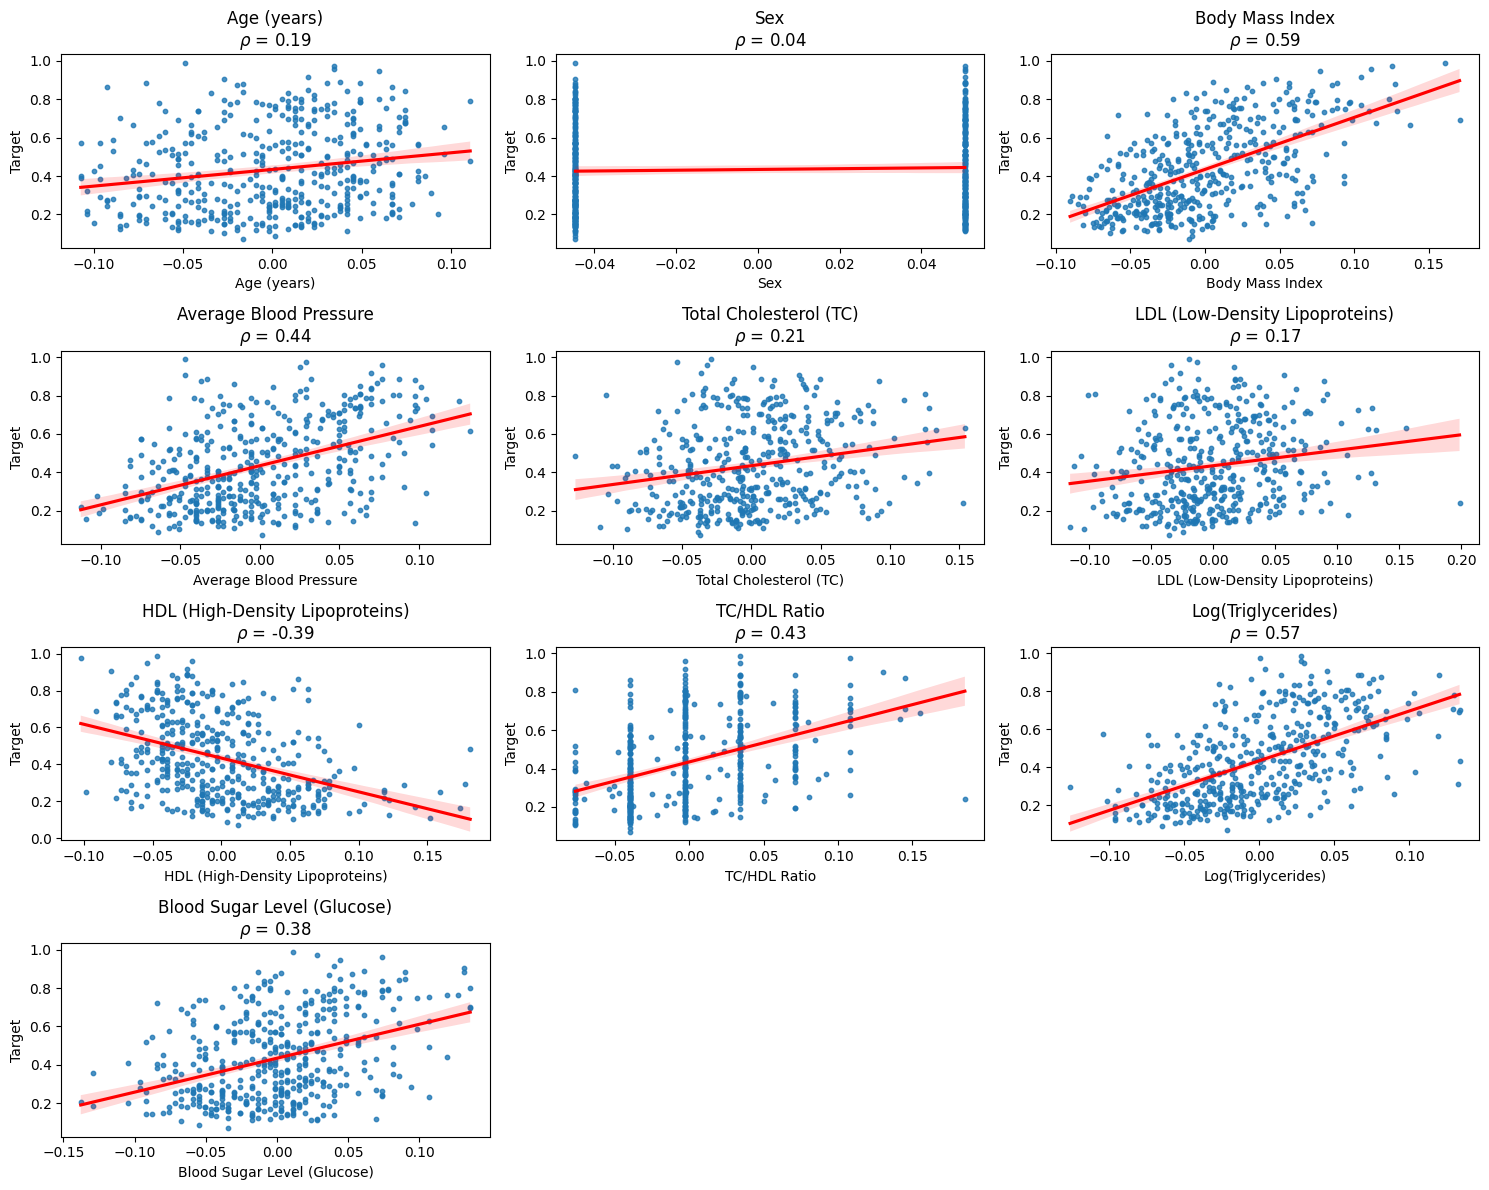

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_feature_correlations(X, y, figsize=(15, 12)):
    """
    Plots each feature in X against the target y with a linear fit and Pearson correlation.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (array-like): Target values.
        figsize (tuple): Size of the overall figure grid.
    """
    import numpy as np
    import math

    n_features = X.shape[1]
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    plt.figure(figsize=figsize)

    for i, column in enumerate(X.columns):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.regplot(x=X[column], y=y, scatter_kws={'s': 10}, line_kws={'color': 'red'})
        corr, _ = pearsonr(X[column], y)
        plt.title(f"{column}\n$\\rho$ = {corr:.2f}")
        plt.xlabel(column)
        plt.ylabel("Target")

    plt.tight_layout()
    plt.show()
plot_feature_correlations(X_renamed, y)

In [5]:
# Split the data into training and test sets

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_renamed, y, test_size=0.4, random_state=42
)

# Second split: 20% validation, 20% test from the temp set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training size: {X_train.shape}")
print(f"Validation size: {X_val.shape}, Test size: {X_test.shape}")

## we sould do a cross validation --> do it at home!

Training size: (265, 10)
Validation size: (88, 10), Test size: (89, 10)


### What is XGBoost?

XGBoost (Extreme Gradient Boosting) is a highly efficient and scalable implementation of gradient boosting for supervised learning tasks such as regression and classification. It builds an ensemble of decision trees sequentially, where each new tree aims to correct the residual errors of the previous ones by minimizing a differentiable loss function. At each iteration, the model adds a new function $\phi(x)$ to the ensemble that best improves the overall prediction:

$$
\hat{y}_i = \sum_{k=1}^K \phi_k(x_i), \quad \phi_k \in \mathcal{F}
$$

where $\mathcal{F}$ is the space of regression trees, and $\phi_k$ represents each individual tree. XGBoost introduces several enhancements such as regularization (via $L_1$ and $L_2$ penalties), shrinkage (learning rate), column and row subsampling, and efficient histogram-based training (`tree_method='hist'`).

In this part we will try to understand what each paramenter of the model do


In [6]:
params = {
    "tree_method": "hist",            # Use histogram-based tree construction (fast and scalable)
    "booster": "gbtree",              # Use gradient boosted trees (not DART or linear booster)
    "learning_rate": 0.05,            # Shrinks the contribution of each tree (also called eta)
    "objective": "reg:squarederror",  # Regression task using squared error as loss function
    "base_score": np.mean(y_train),   # Initial prediction score (use target mean for regression)
    "gamma": 0.05,                     # Minimum loss reduction to make a further split (prunes tree)
    "max_depth": 5,                   # Maximum depth of each tree (controls model complexity)
    "min_child_weight": 5,           # Minimum sum of weights (samples) to create a new child node
    "reg_lambda": 0.5,               # L2 regularization term on weights (Ridge-like)
    "reg_alpha": 0.5,                # L1 regularization term on weights (Lasso-like)
    "n_estimators": 100,            # Maximum number of boosting rounds (trees)
    "eval_metric": "rmse",           # Evaluation metric: root mean squared error
    "colsample_bytree": 0.8,         # Fraction of features to sample for each tree
    "colsample_bylevel": 0.75,        # Fraction of features for each level in a tree
    "colsample_bynode": 0.5,         # Fraction of features for each node split
    "subsample": 0.8,                # Fraction of training data to use per boosting round (row sampling)
    "grow_policy": "lossguide",      # Prioritize splits that reduce loss most (not just depth)
    "validate_parameters": True,     # Ensure parameter values are valid before training
    "n_jobs": 4,                     # Number of threads for parallel computation

}

model = xgb.XGBRegressor(**params)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=np.float64(0.43150404312668467), booster='gbtree',
             callbacks=None, colsample_bylevel=0.75, colsample_bynode=0.5,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.05, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=4, num_parallel_tree=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

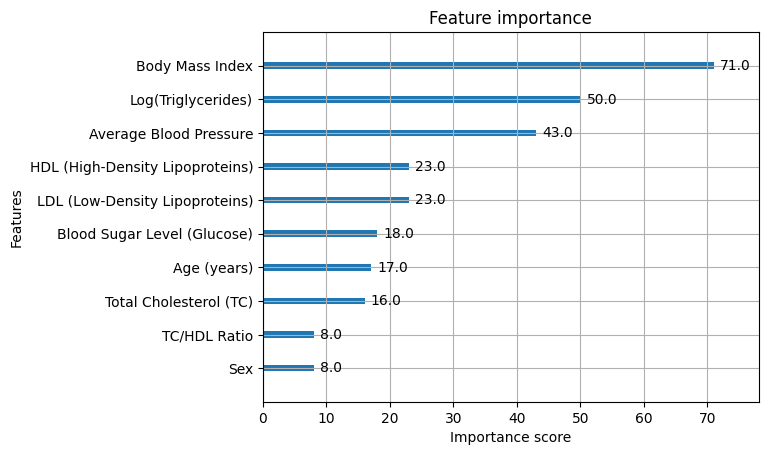

In [7]:
import graphviz
xgb.plot_importance(model)

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


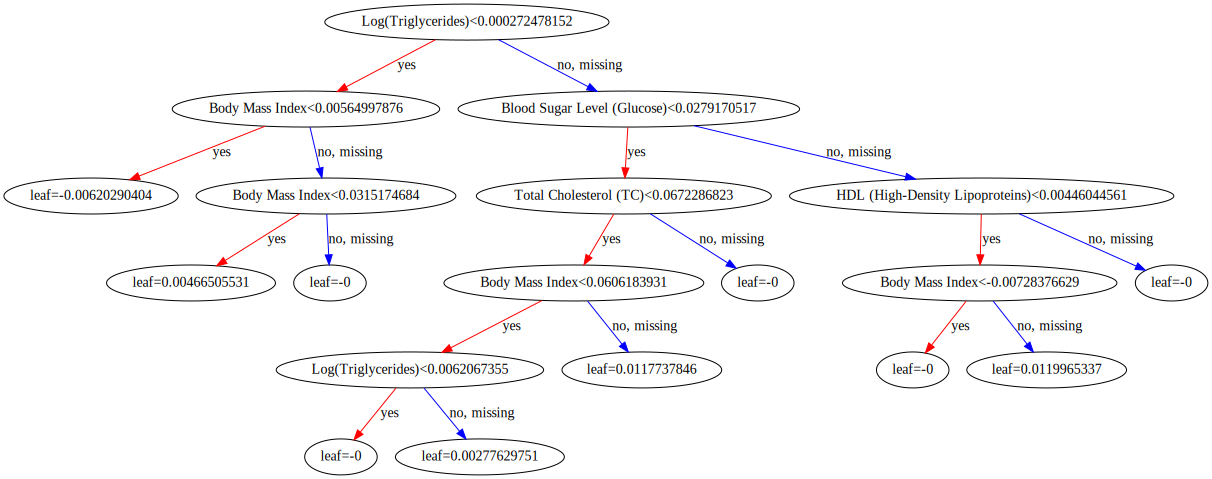

In [8]:
# converts the target tree to a graphviz instance
#xgboost.to_graphviz(model, num_trees=model.best_iteration)
xgb.to_graphviz(model, num_trees=1)

R² on test set: 0.477


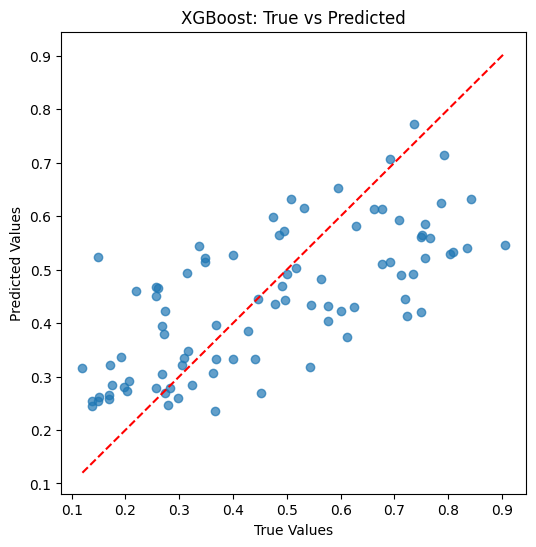

In [9]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Compute R2 score
r2 = r2_score(y_test, predictions)
print(f"R² on test set: {r2:.3f}")

# Scatter plot of true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost: True vs Predicted")
plt.show()


## What is SHAP?

**SHAP (SHapley Additive exPlanations)** is a game‑theoretic framework that explains the output of any machine‑learning model.  
It attributes to each feature the **Shapley value** — the average marginal contribution of that feature across all possible subsets of features.  
Key properties:

* **Additivity**: Model prediction = *base_value* + sum(**SHAP values**)  
* **Consistency**: If a model changes such that a feature contributes more, its SHAP value cannot decrease  
* **Local and Global**: SHAP values can explain individual predictions (local) and be aggregated to understand overall feature importance (global)  

In practice, SHAP helps answer questions like *“Which features push a particular prediction up or down, and by how much?”*


In [10]:
# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

print("Shape of SHAP values:", shap_values.shape)


Shape of SHAP values: (89, 10)


### Interpreting SHAP Values

For each individual prediction, SHAP assigns one value per feature, called a SHAP value, representing how much that feature contributed to pushing the model's output above or below the baseline (expected value). If there are $M$ features, we get $M$ SHAP values per instance, plus a bias term $\phi_0$, such that:

$$
f(x) = \phi_0 + \sum_{i=1}^M \phi_i
$$

A positive SHAP value means the feature increased the prediction, while a negative value decreased it. By aggregating SHAP values across the entire dataset, we can obtain global interpretability — identifying which features are most influential on average and how they affect model predictions overall.


Real value: 0.31
Predicted value: 0.49
Residual: -0.18


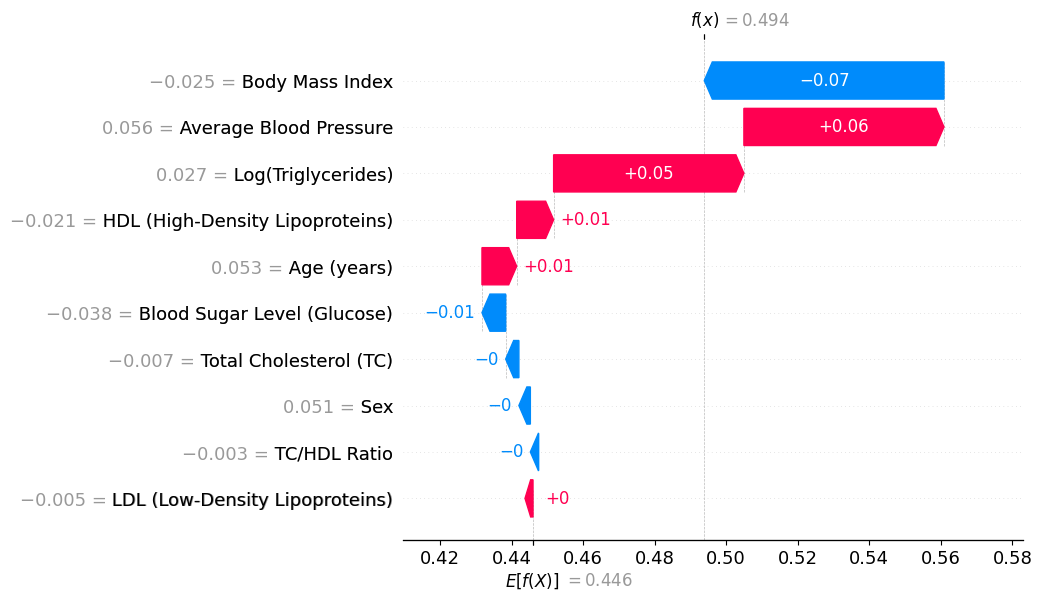

In [11]:
#print real value and prediction for one element and residual
idx=4
print(f"Real value: {y_test[idx]:1.2f}")# ground truth
print(f"Predicted value: {predictions[idx]:1.2f}") # output of the regressor
print(f"Residual: {y_test[idx]-predictions[idx]:1.2f}")
# Display one prediction explanation
shap.plots.waterfall(shap_values[idx])

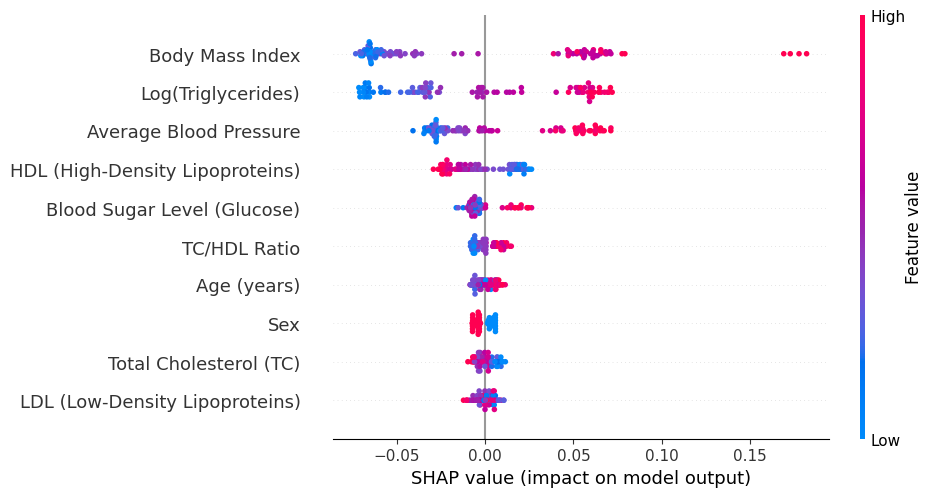

In [12]:
# Summary plot (beeswarm) for global feature importance
shap.plots.beeswarm(shap_values)


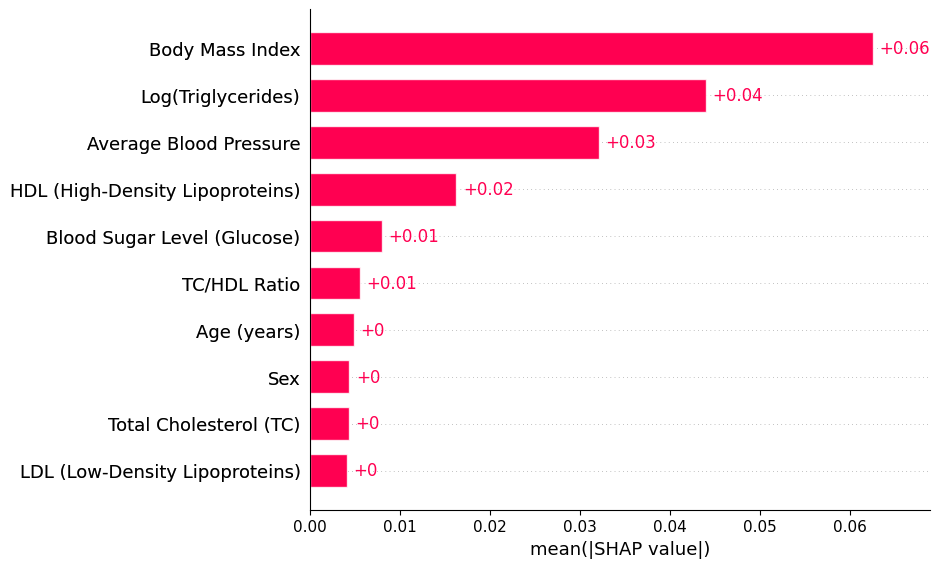

In [13]:
# Bar plot of mean(|SHAP value|) for each feature
shap.plots.bar(shap_values)


['Age (years)', 'Sex', 'Body Mass Index', 'Average Blood Pressure', 'Total Cholesterol (TC)', 'LDL (Low-Density Lipoproteins)', 'HDL (High-Density Lipoproteins)', 'TC/HDL Ratio', 'Log(Triglycerides)', 'Blood Sugar Level (Glucose)']


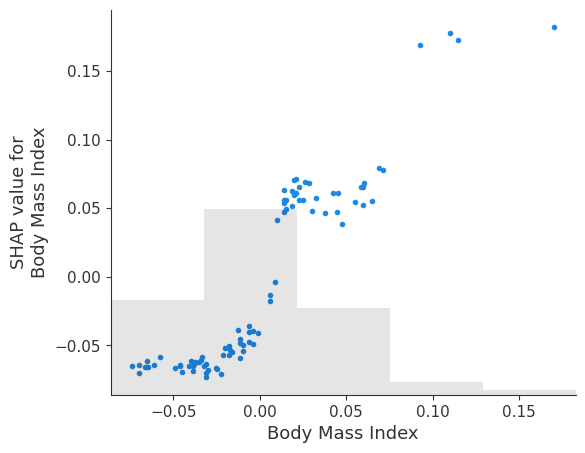

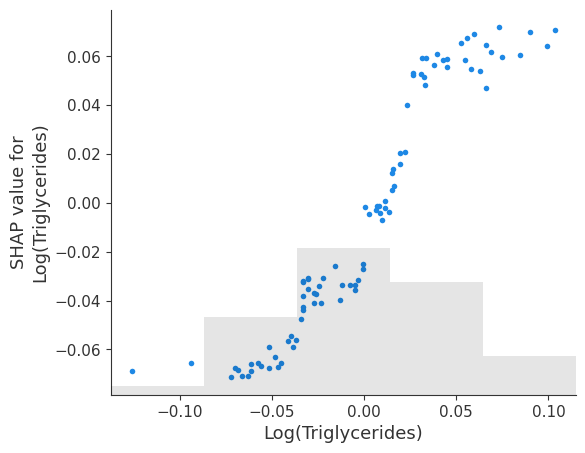

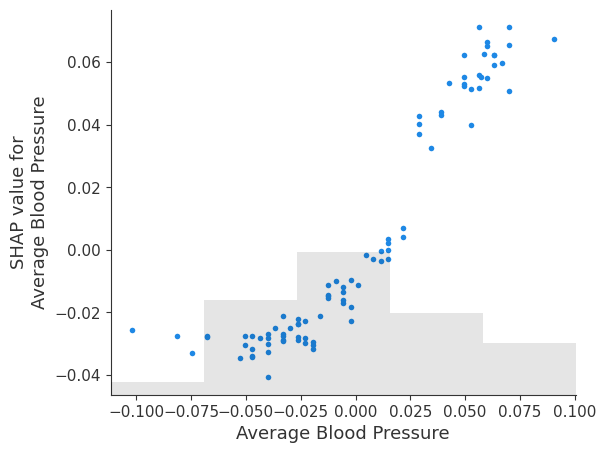

In [14]:
# Dependence plot for a single feature (e.g., 'bmi')
#shap.plots.scatter(shap_values, feature="bmi")
print(shap_values.feature_names)
shap.plots.scatter(shap_values[:, "Body Mass Index"])
shap.plots.scatter(shap_values[:, 'Log(Triglycerides)'])
shap.plots.scatter(shap_values[:, 'Average Blood Pressure'])
